# **Notebook 1**

In this notebook, we will shift our focus from homogenous graphs to heterogeneous graphs. Heterogeneous graphs extend the traditional homogenous graphs that we have seen before by specifically incorperating different node and edge types. This additional information allows us to extend the graph neural nework models that we have worked with before. Namely, we can apply heterogenous message passing, where different message types now exist between different node, edge type relationships.

At first, we will learn how to transform NetworkX graphs into DeepSNAP representations. Additionally, we will dive deeper into how DeepSNAP stores and represents heterogeneous graphs as PyTorch Tensors.

Then, we will build our own heterogenous graph neural netowrk models using PyTorch Geonetric and DeepSNAP on node property prediction task. To evaluate these models, we will use our model on the heterogeneous ACM dataset.

**Note**: Make sure to **sequentially run all the cells in each section**, so that the intermediate variables / packages will carry over to the next cell


# Device
You might need to use GPU for this Colab.

Please click `Runtime` and then `Change runtime type`. Then set the `hardware accelerator` to **GPU**.

# Installation

In [2]:
%pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
%pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
%pip install -q torch-geometric
%pip install -q git+https://github.com/snap-stanford/deepsnap.git
%pip install -U -q PyDrive

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  DEPRECATION: Building 'deepsnap' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'deepsnap'. Discussion can be found at https://github.com/pypa/pip/issues/6334
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch_geometric
torch_geometric.__version__

/root/anaconda3/envs/Graph4/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/root/anaconda3/envs/Graph4/lib/python3.10/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.12: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/root/anaconda3/envs/Graph4/lib/python3.10/site-packages/torch_geometric/typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /root/anaconda3/envs/Graph4/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/root/anaconda3/env

OSError: /root/anaconda3/envs/Graph4/lib/python3.10/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb

# 1 DeepSNAP Heterogeneous Graph

First, we will explore how to transform NetworkX graphs into the format supported by DeepSNAP.

In order to extend the traditional DeepSNAP representation of graphs to include heterogenous graphs, we include the following graph property features:
* `node_feature`: The feature of each node (`torch.tensor`)
* `edge_feature`: The feautre of each edge (`torch.tensor`)
* `node_label`: The label of each node (`int`)
* `node_type`: The node type of each node (`string`)
* `edge_type`: The edge type of each edge (`string`)

The key new features we add are `node_type` and `edge_type`, which enables us to perform heterogenous message passing.

In this first question we will work with the familiar [karate club graph](https://networkx.github.io/documentation/stable/auto_examples/graph/plot_karate_club.html) seen in assignment one. To start, since each node in the graph belongs to one of two clubs (club "Mr. Hi" or club "Officer"), we will treat the club as the `node_type`. The code below demonstrates how to differentiate the nodes in the NetworkX graph.


In [ ]:
from pylab import *
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt
import copy

G = nx.karate_club_graph()
community_map = {}
for node in G.nodes(data=True):
  if node[1]["club"] == "Mr. Hi":
    community_map[node[0]] = 0
  else:
    community_map[node[0]] = 1
node_color = []
color_map = {0: 0, 1: 1}
node_color = [color_map[community_map[node]] for node in G.nodes()]
pos = nx.spring_layout(G)
plt.figure(figsize=(7, 7))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color)
show()

ModuleNotFoundError: No module named 'pylab'

### Question 1.1: Assigning Node Type and Node Features
Using the `community_map` dictionary and graph `G` from above, add node attributes `node_type` and `node_label` to the graph G. Namely, for `node_type` assign nodes in the "Mr. Hi" club to a node type `n0` and nodes in club "Officer" a node type `n1`.

Then for `node_label`, assign nodes in "Mr. Hi" club to a `node_label` `0` and nodes in club "Officer" a `node_label` of `1`.

Lastly, assign every node a feature vector [1, 1, 1, 1, 1].

**Hint**: Look at the NetworkX function `nx.classes.function.set_node_attributes`.

**Note**: This question is not specifically graded but is important for later questions.

In [ ]:
import torch

def assign_node_types(G, community_map):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'node_type' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  attribute_map = { node: "n0" if community_map[node] == 0 else "n1" for node in G.nodes()}
  nx.set_node_attributes(G, attribute_map, "node_type")

  #########################################

def assign_node_labels(G, community_map):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'node_label' as a node_attribute in G.

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  label_map = {node: 0 if community_map[node] == 0 else 1 for node in G.nodes()}
  nx.set_node_attributes(G, label_map, "node_label")

  #########################################

def assign_node_features(G):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and adds 'node_feature' as a node_attribute in G. Each node
  # in the graph has the same feature vector [1., 1., 1., 1., 1.]

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Look up NetworkX `nx.classes.function.set_node_attributes`
  node_map = {node: torch.ones(size=(5, ), dtype=torch.float32) for node in G.nodes()}
  nx.set_node_attributes(G, node_map, "node_feature")
  #########################################

assign_node_types(G, community_map)
assign_node_labels(G, community_map)
assign_node_features(G)


### Question 1.2: Assigning Edge Types

Next, we will assign three different types of `edge_type` to the edges:
* Edges within club "Mr. Hi": `e0`
* Edges within club "Officer": `e1`
* Edges between clubs: `e2`

**Hint**: Use the `community_map` from before and `nx.classes.function.set_edge_attributes`

In [ ]:
def assign_edge_types(G, community_map):
  # TODO: Implement this function that takes in a NetworkX graph
  # G and community map assignment (mapping node ids --> 0/1 labels)
  # and adds 'edge_type' as a edge_attribute in G.

  ############# Your code here ############
  ## (~5 line of code)
  ## Note
  ## 1. Create an edge assignment dict following rules above
  edge_map = {}
  for edge in G.edges():
    if community_map[edge[0]] != community_map[edge[1]]:
      edge_map[edge] = 'e2'
    elif community_map[edge[0]] == 0:
      edge_map[edge] = 'e0'
    else:
      edge_map[edge] = 'e1'
  
  nx.set_edge_attributes(G, edge_map, "edge_type")
  #########################################
assign_edge_types(G, community_map)

## Heterogeneous Graph Visualization

Now we can visualize the Heterogeneous Graph we have generated.

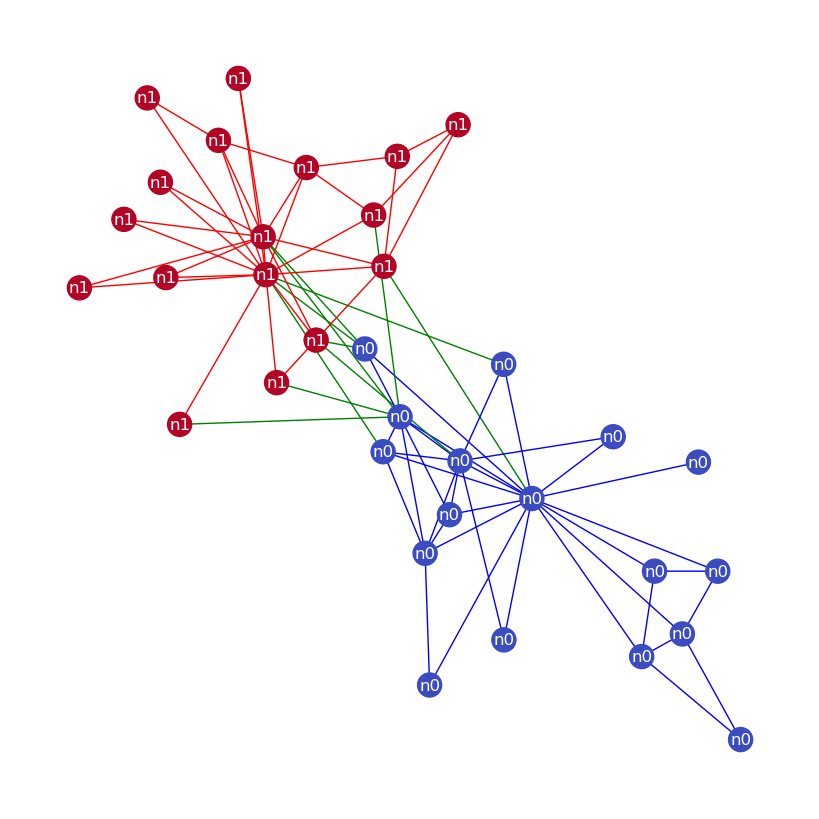

In [ ]:
edge_color = {}
for edge in G.edges():
  n1, n2 = edge
  edge_color[edge] = community_map[n1] if community_map[n1] == community_map[n2] else 2
  if community_map[n1] == community_map[n2] and community_map[n1] == 0:
    edge_color[edge] = 'blue'
  elif community_map[n1] == community_map[n2] and community_map[n1] == 1:
    edge_color[edge] = 'red'
  else:
    edge_color[edge] = 'green'

G_orig = copy.deepcopy(G)
nx.classes.function.set_edge_attributes(G, edge_color, name='color')
colors = nx.get_edge_attributes(G,'color').values()
labels = nx.get_node_attributes(G, 'node_type')
plt.figure(figsize=(8, 8))
nx.draw(G, pos=pos, cmap=plt.get_cmap('coolwarm'), node_color=node_color, edge_color=colors, labels=labels, font_color='white')
show()

which include edges within each clubs (2 types) and edges across two clubs (1 type). Different types of nodes and edges are visualized in different colors. The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly.

## Transforming to DeepSNAP representation

The NetworkX object `G` in following code can be transformed into `deepsnap.hetero_graph.HeteroGraph` directly!

In [ ]:
from deepsnap.hetero_graph import HeteroGraph

hete = HeteroGraph(G_orig)

## Question 1.3: How many nodes are of each type



In [ ]:
def get_nodes_per_type(hete):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of nodes per `node_type`.

  num_nodes_n0 = 0
  num_nodes_n1 = 0

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.

  num_nodes_n0 = hete.num_nodes('n0')
  num_nodes_n1 = hete.num_nodes('n1')

  #########################################

  return num_nodes_n0, num_nodes_n1

num_nodes_n0, num_nodes_n1 = get_nodes_per_type(hete)
print("Node type n0 has {} nodes".format(num_nodes_n0))
print("Node type n1 has {} nodes".format(num_nodes_n1))

Node type n0 has 17 nodes
Node type n1 has 17 nodes


## Question 1.4: Message Types: How many edges are of each message type

When working with heterogenous graphs, as we have discussed before, we now work with heterogenous message types (i.e. different message types for `node_type` and `edge_type` combinations). For example, an edge of type `e0` connecting two nodes in club "Mr. HI" would have a message type of (`n0`, `e0`, `n0`). In this problem we will analyze how many edges in our graph are of each message type.

**Hint**: If you want to learn more about what the different message types are try the call `hete.message_types`

In [ ]:
def get_num_message_edges(hete):
  # TODO: Implement this function that takes a DeepSNAP dataset object
  # and return the number of edges for each message type.
  # You should return a list of tuples as
  # (message_type, num_edge)

  message_type_edges = []

  ############# Your code here ############
  ## (~2 line of code)
  ## Note
  ## 1. Colab autocomplete functionality might be useful.
  for message_type in hete.message_types:
    num_edges = hete.edge_index[message_type].shape[1]
    message_type_edges.append((message_type, num_edges))

  #########################################

  return message_type_edges

message_type_edges = get_num_message_edges(hete)
for (message_type, num_edges) in message_type_edges:
  print("Message type {} has {} edges".format(message_type, num_edges))


Message type ('n0', 'e0', 'n0') has 70 edges
Message type ('n0', 'e2', 'n1') has 22 edges
Message type ('n1', 'e1', 'n1') has 64 edges


## Question 1.5: Dataset Splitting: How many nodes in each dataset split?
DeepSNAP has built in Dataset creation and splitting methods for heterogeneous graphs. Here we will create train, validation, and test datasets for a node prediction task and inspect the resulting subgraphs. Specifically, write a function that computes the number of nodes in each dataset split.


In [ ]:
from deepsnap.dataset import GraphDataset

def compute_dataset_split_counts(datasets):
  # TODO: Implement this function that takes a dict of datasets
  # and returns a dict mapping dataset names to the number of labeled
  # nodes used for supervision in that respective dataset.

  data_set_splits = {}

  ############# Your code here ############
  ## (~3 line of code)
  ## Note
  ## 1. DeepSNAP `node_label_index` will be helpful.
  ## 2. Remember to count both node_types

  for name, dataset in datasets.items():
        num_labeled = 0
        for graph in dataset:
            for indices in graph.node_label_index.values():
                num_labeled += len(indices)
        data_set_splits[name] = num_labeled
  #########################################

  return data_set_splits


dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
datasets = {'train': dataset_train, 'val': dataset_val, 'test': dataset_test}

data_set_splits = compute_dataset_split_counts(datasets)
for dataset_name, num_nodes in data_set_splits.items():
  print("{} dataset has {} nodes".format(dataset_name, num_nodes))

train dataset has 12 nodes
val dataset has 10 nodes
test dataset has 12 nodes


## DeepSNAP Dataset Visualization

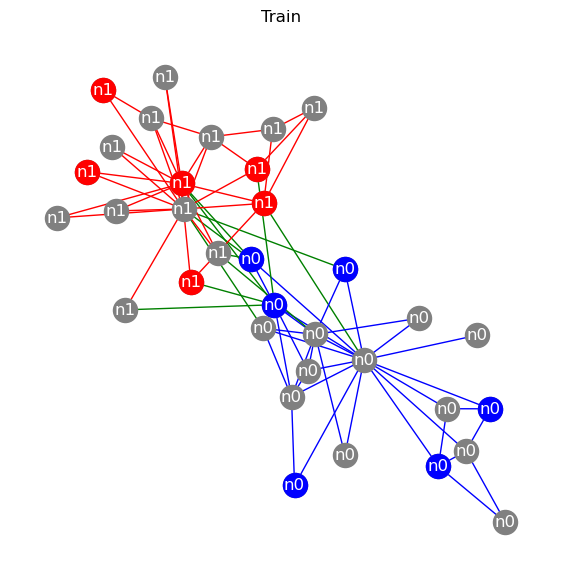

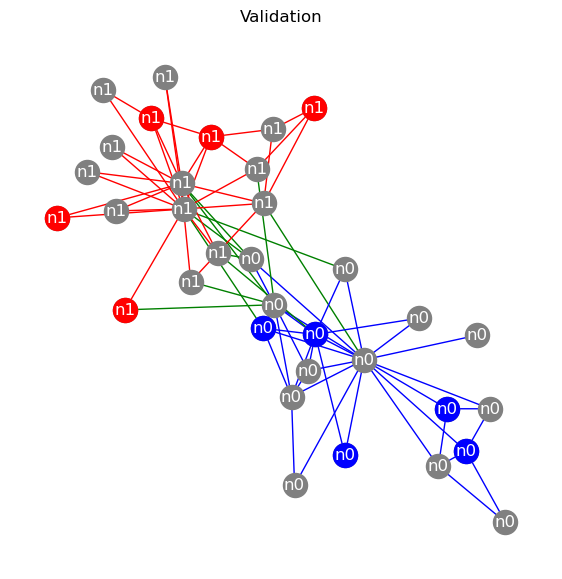

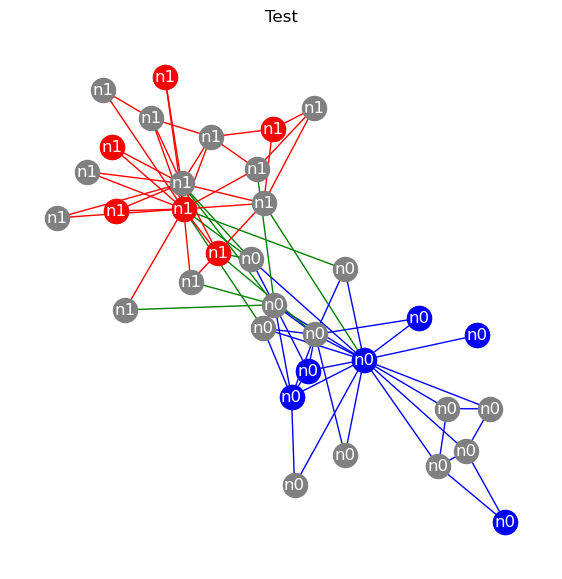

In [ ]:
from deepsnap.dataset import GraphDataset

dataset = GraphDataset([hete], task='node')
# Splitting the dataset
dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.4, 0.3, 0.3])
titles = ['Train', 'Validation', 'Test']

for i, dataset in enumerate([dataset_train, dataset_val, dataset_test]):
  n0 = hete._convert_to_graph_index(dataset[0].node_label_index['n0'], 'n0').tolist()
  n1 = hete._convert_to_graph_index(dataset[0].node_label_index['n1'], 'n1').tolist()

  plt.figure(figsize=(7, 7))
  plt.title(titles[i])
  nx.draw(G_orig, pos=pos, node_color="grey", edge_color=colors, labels=labels, font_color='white')
  nx.draw_networkx_nodes(G_orig.subgraph(n0), pos=pos, node_color="blue")
  nx.draw_networkx_nodes(G_orig.subgraph(n1), pos=pos, node_color="red")
  show()

# 2 Heterogeneous Graph Node Property Prediction

In this part we will use PyTorch Geometric and DeepSNAP to implement a GNN model for heterogeneous graph node property prediction (node classification). This part of Colab requires you having good understandings on the heterogeneous graph and how to implement the GNN layers by using PyG.

At first let's take look at the general structure of a heterogeneous layer by an example.

Let's assume we have a graph $G$, which contains two node types $a$ and $b$, and three message types $m_1=(a, r_1, a)$, $m_2=(a, r_2, b)$ and $m_3=(a, r_3, b)$.

Thus, for $G$ a heterogeneous layer will contains three Heterogeneous GNN layers (`HeteroGNNConv` in this Colab) where each `HeteroGNNConv` layer will perform the message passing and aggregation with respect to only one message type. The overview of the heterogeneous layer is shown below:

<br/>
<center>
<img src="https://web.stanford.edu/class/cs224w/images/colab4/hetero_conv.png"/>
</center>
<br/>

In this Colab, all the $l^{th}$ Heterogeneous GNN layers will be managed by a ($l^{th}$) Heterogeneous GNN Wrapper layer (the `HeteroGNNWrapperConv`). The $l^{th}$ Heterogeneous GNN Wrapper layer will take in the input node embeddings from $(l-1)^{th}$ layer and aggregate (across message types) the Heterogeneous GNN layers' results. For example, the wrapper layer will aggregate node type $b$'s node embeddings from Heterogeneous GNN layers for $m_2$ and $m_3$. The "simplified" heterogeneous layer structure is shown below:

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/hetero_conv_1.png"/>
</center>
<br/>

<font color='red'>We recommend you implement the heterogeneous GNN model in following steps:</font>

1. Implement the `HeteroGNNConv` first.
2. Implement the `mean` aggregation in `HeteroGNNWrapperConv`.
3. Implement the `generate_convs`.
4. Implement the `HeteroGNN` model and the `train` function.
5. Train the model with `mean` aggregation across the message types and make sure your model has reasonable performance.
6. Implement the `attn` aggregation in `HeteroGNNWrapperConv`.
7. Train the model with `attn` aggregation across the message types and make sure your model has reasonable performance.

## Setup

In [ ]:
import torch
print(torch.__version__)

2.5.1+cu124


In [ ]:
import copy
import torch
import deepsnap
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn

from sklearn.metrics import f1_score
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from torch_sparse import SparseTensor, matmul

OSError: /root/anaconda3/envs/GraphLearnHw2/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN3c106detail14torchCheckFailEPKcS2_jRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

## Dataset

You need to login to your Google account and enter the verification code below.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1ivlxd6lJMcZ9taS44TMGG72x2V1GeVvk'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('acm.pkl')

## Heterogeneous GNN Layer

Now let's start working on our own implementation of a heterogeneous layer (the `HeteroGNNConv`)! Similar to what we did in Colab 3, we will implement the layer using PyTorch Geometric. In general, our heterogeneous GNN layer draws ideas from the **GraphSAGE** ([Hamilton et al. (2017)](https://arxiv.org/abs/1706.02216)).

At first, let's implement the GNN layer for each message type :

\begin{equation}
m =(s, r, d)
\end{equation}

Each message type is a tuple containing three elements where $s$ refers to the source node type, $r$ refers to the edge (relation) type and $d$ refers to the destination node type. The update rule is very similar to that of GraphSAGE but we need to include the node types and the edge type. The update rule is described as below:

\begin{equation}
h_v^{(l)[m]} = W^{(l)[m]} \cdot \text{CONCAT} \Big( W_d^{(l)[m]} \cdot h_v^{(l-1)}, W_s^{(l)[m]} \cdot AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \})\Big)
\end{equation}

where $[m]$ indicates that the weight matrices or embeddings with respect to message type $m$, $W_s^{(l)[m]}$ computes the messages from neighboring nodes, $W_d^{(l)[m]}$ compute messages from the node itself, and $W^{(l)[m]}$ aggregates messages from both node types. In the equation above, $v$ has the node type $d$, and $u$ has the node type $s$.

For simplicity, we use mean aggregations for $AGG$ where:

\begin{equation}
AGG(\{h_u^{(l-1)}, \forall u \in N_{m}(v) \}) = \frac{1}{|N_{m}(v)|} \sum_{u\in N_{m}(v)} h_u^{(l-1)}
\end{equation}

In [ ]:
class HeteroGNNConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels_src, in_channels_dst, out_channels):
        super(HeteroGNNConv, self).__init__(aggr="mean")

        self.in_channels_src = in_channels_src
        self.in_channels_dst = in_channels_dst
        self.out_channels = out_channels

        # To simplify implementation, please initialize both self.lin_dst
        # and self.lin_src out_features to out_channels
        self.lin_dst = None
        self.lin_src = None

        self.lin_update = None

        ############# Your code here #############
        ## (~3 lines of code)

        self.lin_dst = pyg_nn.Linear(in_channels_dst, out_channels, bias=False)
        self.lin_src = pyg_nn.Linear(in_channels_src, out_channels, bias=False)

        self.lin_update = pyg_nn.Linear(out_channels * 2, out_channels, bias=False)

        ##########################################

    def forward(
        self,
        node_feature_src,
        node_feature_dst,
        edge_index,
        size=None,
        res_n_id=None,
    ):
        ############# Your code here #############
        ## (~1 line of code)
    

        ##########################################

    def message_and_aggregate(self, edge_index, node_feature_src):

        ############# Your code here #############
        ## (~1 line of code)
        ## Note:
        ## 1. Different from what we implemented in Colab 3, we use message_and_aggregate
        ## to replace the message and aggregate. The benefit is that we can avoid
        ## materializing x_i and x_j, and make the implementation more efficient.
        ## 2. To implement efficiently, following PyG documentation is helpful:
        ## https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html
        ## 3. Here edge_index is torch_sparse SparseTensor.


        ##########################################

        return out

    def update(self, aggr_out, node_feature_dst, res_n_id):

        ############# Your code here #############
        ## (~4 lines of code)


        ##########################################

        return aggr_out

## Heterogeneous GNN Wrapper Layer

After implementing the GNN layer for each message type, we need to somehow aggregate the the node embedding results (with respect to each message types) together. Here we will implement two types of message type level aggregation.

The first one is simply the mean aggregation:

\begin{equation}
h_v^{(l)} = \frac{1}{M}\sum_{m=1}^{M}h_v^{(l)[m]}
\end{equation}

Here node $v$ has the node type $d$ and $M$ is the total number of message types that the destination node type is $d$.

The other one is the semantic level attention introduced in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)). Instead of directly averaging on the message type aggregation results, we use attention to learn which message type result can be more important, then aggregate from all the message types. Following are the equations for semantic level attention:

\begin{equation}
e_{m} = \frac{1}{|V_{d}|} \sum_{v \in V_{d}} q_{attn}^T \cdot tanh \Big( W_{attn}^{(l)} \cdot h_v^{(l)[m]} + b \Big)
\end{equation}

where $m$ refers to message type and $d$ refers to the destination node type. Then we can compute the attention and update the $h_v^{(l)}$:

\begin{equation}
\alpha_{m} = \frac{\exp(e_{m})}{\sum_{m=1}^M \exp(e_{m})}
\end{equation}

\begin{equation}
h_v^{(l)} = \sum_{m=1}^{M} \alpha_{m} \cdot h_v^{(l)[m]}
\end{equation}

In [ ]:
class HeteroGNNWrapperConv(deepsnap.hetero_gnn.HeteroConv):
    def __init__(self, convs, args, aggr="mean"):
        super(HeteroGNNWrapperConv, self).__init__(convs, None)
        self.aggr = aggr

        # Map the index and message type
        self.mapping = {}

        # A numpy array that stores the final attention probability
        self.alpha = None

        self.attn_proj = None

        if self.aggr == "attn":
            ############# Your code here #############
            ## (~1 line of code)
            ## Note:
            ## 1. Initialize self.attn_proj here.
            ## 2. You should use nn.Sequential for self.attn_proj
            ## 3. nn.Linear and nn.Tanh are useful.
            ## 4. You can create a vector parameter by using:
            ## nn.Linear(some_size, 1, bias=False)
            ## 5. The first linear layer should have out_features as args['attn_size']
            ## 6. You can assume we only have one "head" for the attention.
            ## 7. We recommend you to implement the mean aggregation first. After
            ## the mean aggregation works well in the training, then you can
            ## implement this part.


            ##########################################

    def reset_parameters(self):
        super(HeteroConvWrapper, self).reset_parameters()
        if self.aggr == "attn":
            for layer in self.attn_proj.children():
                layer.reset_parameters()

    def forward(self, node_features, edge_indices):
        message_type_emb = {}
        for message_key, message_type in edge_indices.items():
            src_type, edge_type, dst_type = message_key
            node_feature_src = node_features[src_type]
            node_feature_dst = node_features[dst_type]
            edge_index = edge_indices[message_key]
            message_type_emb[message_key] = (
                self.convs[message_key](
                    node_feature_src,
                    node_feature_dst,
                    edge_index,
                )
            )
        node_emb = {dst: [] for _, _, dst in message_type_emb.keys()}
        mapping = {}
        for (src, edge_type, dst), item in message_type_emb.items():
            mapping[len(node_emb[dst])] = (src, edge_type, dst)
            node_emb[dst].append(item)
        self.mapping = mapping
        for node_type, embs in node_emb.items():
            if len(embs) == 1:
                node_emb[node_type] = embs[0]
            else:
                node_emb[node_type] = self.aggregate(embs)
        return node_emb

    def aggregate(self, xs):
        # TODO: Implement this function that aggregates all message type results.
        # Here, xs is a list of tensors (embeddings) with respect to message
        # type aggregation results.

        if self.aggr == "mean":

            ############# Your code here #############
            ## (~2 lines of code)


            ##########################################

        elif self.aggr == "attn":

            ############# Your code here #############
            ## (~10 lines of code)
            ## Note:
            ## 1. Store the value of attention alpha (as a numpy array) to self.alpha,
            ## which has the shape (len(xs), ) self.alpha will be not be used
            ## to backpropagate etc. in the model. We will use it to see how much
            ## attention the layer pays on different message types.
            ## 2. torch.softmax and torch.cat are useful.
            ## 3. You might need to reshape the tensors by using the
            ## `view()` function https://pytorch.org/docs/stable/tensor_view.html


            ##########################################

## Initialize Heterogeneous GNN Layers

Now let's initialize the Heterogeneous GNN Layers. Different from homogeneous graph case, heterogeneous case can be a little bit complex.

In general, we need to create a dictionary of `HeteroGNNConv` layers where the keys are message types.

* To get all message types, `deepsnap.hetero_graph.HeteroGraph.message_types` is useful.
* If we are initializing the first conv layers, we need to get the feature dimension of each node type. Using `deepsnap.hetero_graph.HeteroGraph.num_node_features(node_type)` will return the node feature dimension of `node_type`. In this function, we will set each `HeteroGNNConv` `out_channels` to be `hidden_size`.
* If we are not initializing the first conv layers, all node types will have the same embedding dimension `hidden_size` and we still set `HeteroGNNConv` `out_channels` to be `hidden_size` for simplicity.



In [ ]:
def generate_convs(hetero_graph, conv, hidden_size, first_layer=False):
    # TODO: Implement this function that returns a dictionary of `HeteroGNNConv`
    # layers where the keys are message types. `hetero_graph` is deepsnap `HeteroGraph`
    # object and the `conv` is the `HeteroGNNConv`.

    convs = {}

    ############# Your code here #############
    ## (~9 lines of code)


    ##########################################

    return convs

## HeteroGNN

Now we will make a simple HeteroGNN model which contains only two `HeteroGNNWrapperConv` layers.

For the forward function in `HeteroGNN`, the model is going to be run as following:

$\text{self.convs1} \rightarrow \text{self.bns1} \rightarrow \text{self.relus1} \rightarrow \text{self.convs2} \rightarrow \text{self.bns2} \rightarrow \text{self.relus2} \rightarrow \text{self.postmps}$

In [ ]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, hetero_graph, args, aggr="mean"):
        super(HeteroGNN, self).__init__()

        self.aggr = aggr
        self.hidden_size = args['hidden_size']

        self.convs1 = None
        self.convs2 = None

        self.bns1 = nn.ModuleDict()
        self.bns2 = nn.ModuleDict()
        self.relus1 = nn.ModuleDict()
        self.relus2 = nn.ModuleDict()
        self.post_mps = nn.ModuleDict()

        ############# Your code here #############
        ## (~10 lines of code)
        ## Note:
        ## 1. For self.convs1 and self.convs2, call generate_convs at first and then
        ## pass the returned dictionary of `HeteroGNNConv` to `HeteroGNNWrapperConv`.
        ## 2. For self.bns, self.relus and self.post_mps, the keys are node_types.
        ## `deepsnap.hetero_graph.HeteroGraph.node_types` will be helpful.
        ## 3. Initialize all batchnorms to torch.nn.BatchNorm1d(hidden_size, eps=1.0).
        ## 4. Initialize all relus to nn.LeakyReLU().
        ## 5. For self.post_mps, each value in the ModuleDict is a linear layer
        ## where the `out_features` is the number of classes for that node type.
        ## `deepsnap.hetero_graph.HeteroGraph.num_node_labels(node_type)` will be
        ## useful.


        ##########################################

    def forward(self, node_feature, edge_index):
        # TODO: Implement the forward function. Notice that `node_feature` is
        # a dictionary of tensors where keys are node types and values are
        # corresponding feature tensors. The `edge_index` is a dictionary of
        # tensors where keys are message types and values are corresponding
        # edge index tensors (with respect to each message type).

        x = node_feature

        ############# Your code here #############
        ## (~7 lines of code)
        ## Note:
        ## 1. `deepsnap.hetero_gnn.forward_op` can be helpful.


        ##########################################

        return x

    def loss(self, preds, y, indices):

        loss = 0
        loss_func = F.cross_entropy

        ############# Your code here #############
        ## (~3 lines of code)
        ## Note:
        ## 1. For each node type in preds, accumulate computed loss to `loss`
        ## 2. Loss need to be computed with respect to the given index


        ##########################################

        return loss

## Training and Testing

Here we provide you with the functions to train and test. You only need to implement one line of code here.

**Please do not modify other parts in `train` and `test` for grading purposes.**

In [ ]:
def train(model, optimizer, hetero_graph, train_idx):
    model.train()
    optimizer.zero_grad()
    preds = model(hetero_graph.node_feature, hetero_graph.edge_index)

    loss = None

    ############# Your code here #############
    ## Note:
    ## 1. `deepsnap.hetero_graph.HeteroGraph.node_label` is useful
    ## 2. Compute the loss here


    ##########################################

    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, graph, indices, best_model=None, best_val=0):
    model.eval()
    accs = []
    for index in indices:
        preds = model(graph.node_feature, graph.edge_index)
        num_node_types = 0
        micro = 0
        macro = 0
        for node_type in preds:
            idx = index[node_type]
            pred = preds[node_type][idx]
            pred = pred.max(1)[1]
            label_np = graph.node_label[node_type][idx].cpu().numpy()
            pred_np = pred.cpu().numpy()
            micro = f1_score(label_np, pred_np, average='micro')
            macro = f1_score(label_np, pred_np, average='macro')
            num_node_types += 1
        # Averaging f1 score might not make sense, but in our example we only
        # have one node type
        micro /= num_node_types
        macro /= num_node_types
        accs.append((micro, macro))
    if accs[1][0] > best_val:
        best_val = accs[1][0]
        best_model = copy.deepcopy(model)
    return accs, best_model, best_val

In [ ]:
# Please do not change the following parameters
args = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'hidden_size': 64,
    'epochs': 100,
    'weight_decay': 1e-5,
    'lr': 0.003,
    'attn_size': 32,
}

## Dataset and Preprocessing

In the next, we will load the data and create a tensor backend (without a NetworkX graph) `deepsnap.hetero_graph.HeteroGraph` object.

We will use the `ACM(3025)` dataset in our node property prediction task, which is proposed in **HAN** ([Wang et al. (2019)](https://arxiv.org/abs/1903.07293)) and our dataset is extracted from [DGL](https://www.dgl.ai/)'s [ACM.mat](https://data.dgl.ai/dataset/ACM.mat).

The original ACM dataset has three node types and two edge (relation) types. For simplicity, we simplify the heterogeneous graph to one node type and two edge types (shown below). This means that in our heterogeneous graph, we have one node type (paper) and two message types (paper, author, paper) and (paper, subject, paper).

<br/>
<center>
<img src="http://web.stanford.edu/class/cs224w/images/colab4/cs224w-acm.png"/>
</center>

In [ ]:
print("Device: {}".format(args['device']))

# Load the data
data = torch.load("acm.pkl")

# Message types
message_type_1 = ("paper", "author", "paper")
message_type_2 = ("paper", "subject", "paper")

# Dictionary of edge indices
edge_index = {}
edge_index[message_type_1] = data['pap']
edge_index[message_type_2] = data['psp']

# Dictionary of node features
node_feature = {}
node_feature["paper"] = data['feature']

# Dictionary of node labels
node_label = {}
node_label["paper"] = data['label']

# Load the train, validation and test indices
train_idx = {"paper": data['train_idx'].to(args['device'])}
val_idx = {"paper": data['val_idx'].to(args['device'])}
test_idx = {"paper": data['test_idx'].to(args['device'])}

# Construct a deepsnap tensor backend HeteroGraph
hetero_graph = HeteroGraph(
    node_feature=node_feature,
    node_label=node_label,
    edge_index=edge_index,
    directed=True
)

print(f"ACM heterogeneous graph: {hetero_graph.num_nodes()} nodes, {hetero_graph.num_edges()} edges")

# Node feature and node label to device
for key in hetero_graph.node_feature:
    hetero_graph.node_feature[key] = hetero_graph.node_feature[key].to(args['device'])
for key in hetero_graph.node_label:
    hetero_graph.node_label[key] = hetero_graph.node_label[key].to(args['device'])

# Edge_index to sparse tensor and to device
for key in hetero_graph.edge_index:
    edge_index = hetero_graph.edge_index[key]
    adj = SparseTensor(row=edge_index[0], col=edge_index[1], sparse_sizes=(hetero_graph.num_nodes('paper'), hetero_graph.num_nodes('paper')))
    hetero_graph.edge_index[key] = adj.t().to(args['device'])
print(hetero_graph.edge_index[message_type_1])
print(hetero_graph.edge_index[message_type_2])

## Start Training!

Now lets start training!

## Training the Mean Aggregation

In [ ]:
best_model = None
best_val = 0

model = HeteroGNN(hetero_graph, args, aggr="mean").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

## Question 2.1: What is the maximum **micro** F1 score you could get for the best_model on test set when using the mean aggregation?


## Question 2.2: What is the maximum **macro** F1 score you could get for the best_model on test set when using the mean aggregation?

## Training the Attention Aggregation

In [ ]:
best_model = None
best_val = 0

output_size = hetero_graph.num_node_labels('paper')
model = HeteroGNN(hetero_graph, args, aggr="attn").to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

for epoch in range(args['epochs']):
    loss = train(model, optimizer, hetero_graph, train_idx)
    accs, best_model, best_val = test(model, hetero_graph, [train_idx, val_idx, test_idx], best_model, best_val)
    print(
        f"Epoch {epoch + 1}: loss {round(loss, 5)}, "
        f"train micro {round(accs[0][0] * 100, 2)}%, train macro {round(accs[0][1] * 100, 2)}%, "
        f"valid micro {round(accs[1][0] * 100, 2)}%, valid macro {round(accs[1][1] * 100, 2)}%, "
        f"test micro {round(accs[2][0] * 100, 2)}%, test macro {round(accs[2][1] * 100, 2)}%"
    )
best_accs, _, _ = test(best_model, hetero_graph, [train_idx, val_idx, test_idx])
print(
    f"Best model: "
    f"train micro {round(best_accs[0][0] * 100, 2)}%, train macro {round(best_accs[0][1] * 100, 2)}%, "
    f"valid micro {round(best_accs[1][0] * 100, 2)}%, valid macro {round(best_accs[1][1] * 100, 2)}%, "
    f"test micro {round(best_accs[2][0] * 100, 2)}%, test macro {round(best_accs[2][1] * 100, 2)}%"
)

## Question 2.3: What is the maximum **micro** F1 score you could get for the best_model on test set when using the attention aggregation?

## Question 2.4: What is the maximum **macro** F1 score you could get for the best_model on test set when using the attention aggregation?


## Attention for each Message Type

Through message type level attention we can learn that which message type is more important to which layer.

Here we will print out and show that each layer pay how much attention on each message type.

In [ ]:
if model.convs1.alpha is not None and model.convs2.alpha is not None:
    for idx, message_type in model.convs1.mapping.items():
        print(f"Layer 1 has attention {model.convs1.alpha[idx]} on message type {message_type}")
    for idx, message_type in model.convs2.mapping.items():
        print(f"Layer 2 has attention {model.convs2.alpha[idx]} on message type {message_type}")